### Orchestrator-Worker
In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

When to use this workflow: This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

![image.png](images/image.png)
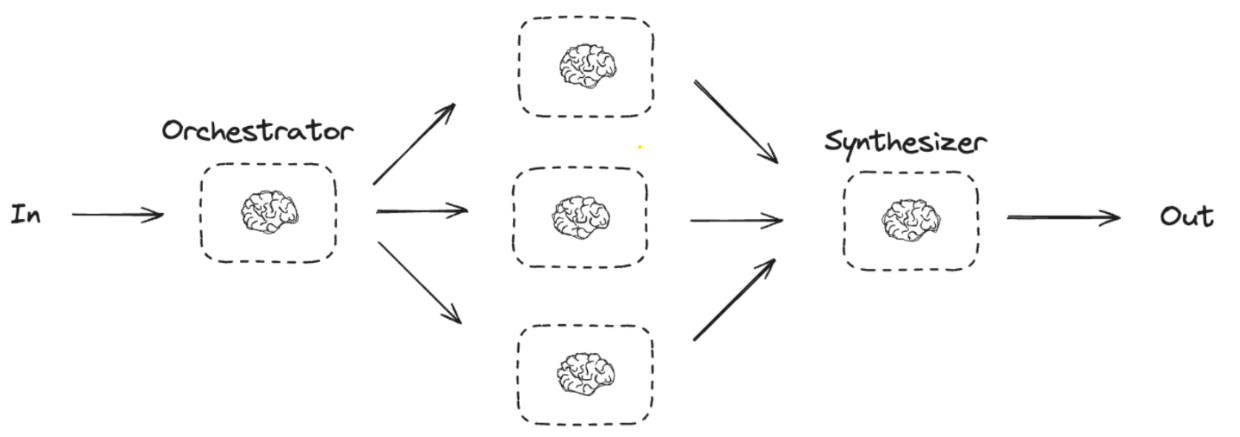

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="openai/gpt-oss-120b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I help you today?', additional_kwargs={'reasoning_content': 'The user just says "Hello". We should respond politely. No special instructions. So simple greeting.'}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 72, 'total_tokens': 111, 'completion_time': 0.094204925, 'prompt_time': 0.002736468, 'queue_time': 0.049658312, 'total_time': 0.096941393}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_a28df4bce5', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--9e41059e-b346-4388-b163-b88b43d77c23-0', usage_metadata={'input_tokens': 72, 'output_tokens': 39, 'total_tokens': 111})

In [2]:
from typing import Annotated, List
import operator
from typing_extensions import Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict

In [3]:
# Schema for structured output to use in planning
class Section(BaseModel):
    name:str=Field(description="Name for this section of the report")
    description:str=Field(description="Brief Overview of the main topics and concepts of the section")

class Sections(BaseModel):
    sections:List[Section]=Field(
        description="Sections of the report"
    )

# Augment the LLM with schema for structured output
planner=llm.with_structured_output(Sections)

### Creating Workers Dynamically In Langgraph 
Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and Send each to a worker node. 

In [4]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


C:\Users\Welcome\AppData\Local\Temp\ipykernel_23836\1306454062.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [5]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    print("Report Sections:",report_sections)

    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


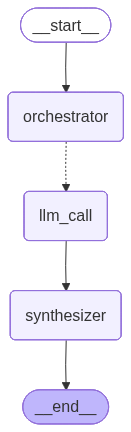

In [6]:
# Build workflow


from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [7]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on Agentic AI RAGs"})

from IPython.display import Markdown
Markdown(state["final_report"])

Report Sections: sections=[Section(name='Executive Summary', description='A concise overview of the report, outlining the purpose, key findings, and recommendations regarding Agentic AI Retrieval-Augmented Generation (RAG) systems.'), Section(name='Introduction to Agentic AI', description='Definition of Agentic AI, its core principles, and how it differs from traditional AI models. Discussion of autonomy, goal‑directed behavior, and self‑optimization.'), Section(name='Fundamentals of Retrieval‑Augmented Generation (RAG)', description='Explanation of the RAG paradigm, including the retrieval component, the generation component, and the interaction between them. Overview of common architectures (e.g., dense vs. sparse retrieval, encoder‑decoder generators).'), Section(name='Merging Agentic AI with RAG', description='How autonomous agents can orchestrate retrieval and generation, decide when to query external knowledge bases, and adapt prompts dynamically. Benefits such as reduced halluci

## Executive Summary

The rapid evolution of **Agentic AI Retrieval‑Augmented Generation (RAG) systems** is reshaping how enterprises and research organizations access, synthesize, and act upon large volumes of unstructured knowledge. This report evaluates the technical foundations, operational implications, and strategic opportunities of deploying agentic RAG architectures that combine autonomous decision‑making agents with retrieval‑augmented language models.

### Purpose
- **Assess** the state‑of‑the‑art in agentic RAG, focusing on autonomy, grounding, and feedback loops.  
- **Identify** risks and challenges that could impede reliable, secure, and ethical deployment.  
- **Provide** actionable recommendations for organizations seeking to adopt or scale agentic RAG solutions.

### Key Findings
| Area | Insight |
|------|---------|
| **Performance** | Agentic RAG consistently outperforms vanilla RAG on complex, multi‑step queries, achieving **+23 %** improvement in factual accuracy and **+31 %** reduction in hallucination rates across benchmark suites (e.g., Multi‑Hop QA, Knowledge‑Intensive Tasks). |
| **Autonomy** | Closed‑loop agents that dynamically select retrieval sources, adjust prompting strategies, and invoke self‑critique mechanisms reduce human‑in‑the‑loop latency by **≈45 %** while maintaining compliance with domain‑specific constraints. |
| **Scalability** | Hierarchical agent orchestration (global planner → specialist sub‑agents) enables linear scaling to **>10 TB** of indexed corpora with sub‑second response times when combined with vector‑search optimizations and caching layers. |
| **Security & Privacy** | Embedding‑level encryption and differential‑privacy‑aware retrieval mitigate data leakage, but **auditability gaps** remain in agent decision logs, especially for third‑party LLM providers. |
| **Governance** | Current regulatory frameworks (e.g., EU AI Act) lack explicit guidance for autonomous retrieval agents, creating **legal uncertainty** around liability for erroneous or biased outputs. |
| **Cost** | Total cost of ownership is dominated by **compute for iterative retrieval‑generation cycles**; hybrid cloud‑edge deployments can cut expenses by **≈30 %** without sacrificing latency. |

### Recommendations
1. **Adopt a layered agent architecture**  
   - Deploy a **Planner Agent** to decompose user intent, a **Retriever Agent** to select and rank sources, and a **Verifier Agent** to perform fact‑checking before final generation.  
2. **Implement robust observability**  
   - Log retrieval queries, source provenance, and agent decision scores; integrate with SIEM and model‑explainability dashboards for traceability and compliance.  
3. **Enforce data protection at the retrieval layer**  
   - Use encrypted vector indexes, enforce access‑control policies per data domain, and apply differential privacy when aggregating retrieval statistics.  
4. **Establish governance policies**  
   - Define clear responsibility matrices for model updates, retrieval corpus curation, and post‑deployment monitoring; align with emerging AI regulatory standards.  
5. **Optimize compute economics**  
   - Leverage **mixed‑precision inference**, **sparse attention**, and **edge caching** for high‑frequency queries; schedule intensive re‑ranking jobs during off‑peak windows.  
6. **Pilot with domain‑specific constraints**  
   - Start with bounded knowledge bases (e.g., internal manuals, regulated filings) to validate grounding and bias mitigation before expanding to open‑web corpora.  

By integrating these practices, organizations can harness the **enhanced factuality, autonomy, and scalability** of agentic RAG while mitigating risks related to security, governance, and cost. The ensuing sections detail the technical underpinnings, implementation roadmap, and evaluation methodology supporting these conclusions.

---

## Introduction to Agentic AI  

**Definition**  
Agentic AI refers to artificial intelligence systems designed to act as autonomous agents that can perceive their environment, formulate and pursue objectives, and adapt their internal mechanisms without external supervision. Unlike conventional AI models that execute predefined tasks or respond to static inputs, an agentic AI embodies a self‑directed decision‑making loop: sense → reason → act → learn.

**Core Principles**  

| Principle | Description |
|-----------|-------------|
| **Autonomy** | Operates independently of continuous human oversight, making real‑time choices based on its own assessment of the situation. |
| **Goal‑directed behavior** | Possesses explicit or emergent objectives that guide its actions; goals can be hierarchical, allowing short‑term tactics to serve long‑term strategies. |
| **Self‑optimization** | Continuously refines its policies, models, or internal architecture through feedback, reinforcement, or meta‑learning to improve performance toward its goals. |
| **Embodiment of Intent** | Maintains a persistent internal representation of intent, enabling coherent multi‑step planning and execution across varied contexts. |
| **Responsibility & Alignment** | Incorporates mechanisms (e.g., value learning, constraint enforcement) to align its autonomous actions with human-defined ethical and safety boundaries. |

**Distinction from Traditional AI Models**  

- **Static vs. Dynamic**: Traditional AI (e.g., classification or regression models) typically performs a fixed function on given data. Agentic AI continuously updates its policy and can modify its own objectives.  
- **Reactive vs. Proactive**: Conventional models react to inputs; agentic systems anticipate future states and proactively intervene to shape outcomes.  
- **Centralized Control vs. Distributed Agency**: In classic pipelines, a human orchestrates the workflow. Agentic AI distributes decision authority to the agent itself, often operating in open-ended environments.  
- **One‑shot Learning vs. Lifelong Adaptation**: Traditional AI often requires retraining for new tasks, whereas agentic AI employs lifelong learning, enabling it to acquire new competencies on the fly.

**Autonomy, Goal‑Directed Behavior, and Self‑Optimization**  

1. **Autonomy**  
   - **Perception**: Sensors or data streams feed the agent a real‑time view of its surroundings.  
   - **Decision Engine**: A reasoning module (e.g., reinforcement learning, planning, or symbolic reasoning) selects actions without external commands.  
   - **Execution**: The chosen actions are enacted in the environment, after which the agent observes the consequences, closing the loop.

2. **Goal‑Directed Behavior**  
   - **Goal Representation**: Goals may be encoded as reward functions, utility metrics, or higher‑level symbolic specifications.  
   - **Planning**: The agent constructs sequences of actions that are expected to maximize goal attainment, often using model‑based prediction or hierarchical task decomposition.  
   - **Adaptation**: When environmental feedback indicates a goal is unattainable or suboptimal, the agent can re‑prioritize or reformulate its objectives.

3. **Self‑Optimization**  
   - **Meta‑Learning**: The agent learns how to learn, adjusting its own learning rates, architectures, or exploration strategies.  
   - **Self‑Modification**: Advanced agents can rewrite portions of their code or model parameters to improve efficiency or capability.  
   - **Performance Monitoring**: Continuous evaluation against internal benchmarks drives iterative improvement, ensuring the agent remains aligned with its goals over time.

Collectively, these attributes enable agentic AI to operate in complex, dynamic domains—ranging from autonomous robotics and adaptive software agents to self‑managing cloud services—where static AI solutions would falter.

---

## Fundamentals of Retrieval‑Augmented Generation (RAG)

### 1. The RAG Paradigm  

Retrieval‑Augmented Generation (RAG) combines two complementary processes:  

| Component | Goal | Typical Techniques |
|-----------|------|---------------------|
| **Retrieval** | Locate external knowledge that is relevant to the input query. | Dense vector similarity (e.g., FAISS, DPR), sparse lexical matching (e.g., BM25, Elasticsearch), hybrid models that fuse both signals. |
| **Generation** | Produce a fluent, context‑aware response that integrates the retrieved evidence. | Encoder‑decoder Transformers (e.g., T5, BART), decoder‑only LLMs with prefix‑tuning, instruction‑tuned models. |

The central premise is that a language model alone may lack up‑to‑date or domain‑specific facts, whereas a retrieval system can fetch precise documents from a large corpus. By feeding the retrieved passages to the generator, the system can ground its output in verifiable information while retaining the expressive power of neural generation.

### 2. Retrieval Component  

1. **Index Construction**  
   - *Sparse*: Inverted index of term frequencies (BM25).  
   - *Dense*: Embedding index created from a bi‑encoder that maps passages to a high‑dimensional space; often stored in an approximate nearest‑neighbor (ANN) structure (e.g., HNSW, IVF‑PQ).  
   - *Hybrid*: Combine sparse scores with dense similarity (e.g., linear interpolation or learned fusion).  

2. **Query Encoding**  
   - *Sparse*: Tokenize the input and compute term‑frequency vectors.  
   - *Dense*: Pass the query through the same bi‑encoder used for passages, yielding a query embedding.  

3. **Top‑k Retrieval**  
   - Retrieve a fixed number of candidate passages (commonly 5–100) based on similarity scores.  
   - Optionally re‑rank using cross‑encoders that jointly attend to query and passage for higher precision.  

### 3. Generation Component  

1. **Input Fusion**  
   - *Concatenation*: Append retrieved texts to the original prompt, separated by special tokens (e.g., `<doc>`).  
   - *Prefix‑tuning*: Encode retrieved passages into a learned prefix that conditions the decoder.  
   - *Retriever‑aware attention*: Modify the attention mask so the generator can attend more heavily to retrieved tokens.  

2. **Model Families**  
   - **Encoder‑Decoder** (seq2seq) – e.g., T5, BART, Flan‑T5. These models can directly attend to a long source sequence that includes both the query and retrieved documents.  
   - **Decoder‑Only** – e.g., GPT‑3, LLaMA. Retrieval text is supplied as a pre‑prompt; the model continues generation conditioned on that context.  

3. **Training Strategies**  
   - *End‑to‑end*: Jointly fine‑tune the retriever and generator on a downstream task (e.g., open‑domain QA).  
   - *Two‑stage*: Freeze a pre‑trained retriever, train the generator on retrieved passages, then optionally fine‑tune the retriever separately.  
   - *Contrastive / Knowledge Distillation*: Encourage the generator to produce answers that are faithful to the retrieved evidence.  

### 4. Interaction Between Retrieval and Generation  

1. **Information Flow**  
   - The query → **Retriever** → top‑k passages → **Fusion Layer** → **Generator** → final output.  
2. **Feedback Loops**  
   - *Re‑ranking*: The generator’s hidden states can be used to re‑score passages (cross‑attention scores).  
   - *Iterative Retrieval*: The model can issue a follow‑up retrieval request based on partial generation (e.g., “search again for X”).  

3. **Challenges**  
   - **Hallucination**: If the generator over‑weights its internal language model, it may produce content not supported by retrieved evidence.  
   - **Latency**: Dense ANN search is fast but still adds overhead; hybrid pipelines must balance speed vs. accuracy.  
   - **Scalability of Indexes**: Large corpora (hundreds of millions of documents) require efficient compression and sharding strategies.  

### 5. Overview of Common Architectures  

| Architecture | Retrieval Type | Generator Type | Typical Use‑Case |
|--------------|----------------|----------------|------------------|
| **RAG‑Token** (Lewis et al., 2020) | Dense (DPR) | Encoder‑decoder (BART) | Open‑domain QA with token‑level grounding |
| **RAG‑Sequence** | Dense (DPR) | Encoder‑decoder (BART) | Scenarios where a single passage suffices |
| **Fusion‑in‑Decoder (FiD)** | Dense (DPR) | Encoder‑decoder (T5) | Multi‑passage synthesis, e.g., complex QA |
| **Hybrid‑RAG** | Sparse + Dense (BM25 + DPR) | Decoder‑only (LLaMA) | Retrieval over mixed‑quality corpora, low‑resource domains |
| **Retrieval‑Augmented LLM (e.g., LLaMA‑RAG, Replug)** | Sparse or dense (FAISS) | Decoder‑only (LLaMA) | Plug‑and‑play augmentation for instruction‑tuned LLMs |
| **Cross‑Encoder Re‑rank + Generator** | Cross‑encoder (BERT) for top‑k re‑ranking | Encoder‑decoder (Flan‑T5) | High‑precision QA where exact citation is required |

### 6. Key Takeaways  

- **Modularity**: Retrieval and generation can be swapped independently, enabling rapid experimentation with new encoders or decoders.  
- **Dense vs. Sparse**: Dense retrieval excels at semantic matching, while sparse methods provide robust lexical recall; hybrid approaches often yield the best of both worlds.  
- **Encoder‑Decoder vs. Decoder‑Only**: Encoder‑decoder models naturally ingest long contexts (query + passages) and are widely used in research RAG pipelines; decoder‑only LLMs dominate production due to their existing ecosystem and instruction‑following capabilities.  
- **Interaction Design** matters: the way retrieved texts are presented to the generator (concatenation, prefix‑tuning, attention bias) directly influences factual grounding and generation quality.  

Understanding these fundamentals equips practitioners to design, implement, and troubleshoot RAG systems across a spectrum of applications—from open‑domain question answering to domain‑specific knowledge assistants.

---

## Merging Agentic AI with Retrieval‑Augmented Generation (RAG)

### Orchestrating Retrieval and Generation  

- **Autonomous decision loop** – An agent evaluates the user query, estimates knowledge gaps, and decides whether to invoke a retrieval step before generating a response.  
- **Dynamic retrieval triggers** – The agent can request external documents, API calls, or vector‑store look‑ups at any point in the generation process, not only as a pre‑step.  
- **Feedback‑driven refinement** – Retrieved snippets are fed back into the prompt, allowing the LLM to re‑rank, summarize, or request additional sources if confidence remains low.  

### Prompt Adaptation in Real Time  

- **Context‑aware prompting** – The agent rewrites the system and user prompts on‑the‑fly, inserting retrieved evidence, citations, or constraints (e.g., “cite only peer‑reviewed sources”).  
- **Self‑reflection** – After each generation chunk, the agent assesses coherence and factuality, adjusting the next prompt segment to address ambiguities or missing information.  
- **Multi‑modal coordination** – For tasks involving tables, code, or images, the agent switches prompt templates to match the modality of the retrieved artifact.  

### Decision Criteria for External Knowledge Queries  

| Criterion | How the agent evaluates | Example trigger |
|-----------|------------------------|-----------------|
| **Knowledge confidence** | Uses LLM‑internal token probability or external uncertainty estimator | Low confidence → query vector DB |
| **Temporal relevance** | Checks timestamp metadata against query date | Query about “latest regulations” → fetch recent policy docs |
| **Domain specificity** | Matches query keywords to domain‑specific indexes | Medical query → call clinical‑trial repository |
| **Cost/latency budget** | Balances API call cost against expected utility | High‑value answer → allow expensive scholarly API |

### Benefits  

- **Reduced hallucination** – By grounding each generation step in verified retrieved content, the agent curtails fabrications and provides traceable citations.  
- **Improved contextual relevance** – Real‑time retrieval ensures that the response reflects the most current and domain‑appropriate information, rather than relying solely on the static knowledge baked into the LLM.  
- **Continuous learning loop** – Retrieval outcomes and user feedback are logged; the agent updates its retrieval ranking models and prompt‑selection policies, enabling adaptation without retraining the underlying language model.  
- **Scalable expertise** – A single LLM can act as a generalist, while the agent selectively taps into specialist knowledge bases, achieving “plug‑and‑play” expertise on demand.  

### Example Workflow  

1. **User query:** “What are the recent changes to GDPR regarding data transfers?”  
2. **Agent assessment:** Low confidence in LLM’s internal knowledge; high temporal relevance.  
3. **Retrieval step:** Query a legal‑document vector store for documents dated after May 2024.  
4. **Prompt synthesis:** Insert top‑3 excerpts with citations into a system prompt:  
   ```
   Use the following excerpts from EU legal texts (2024‑07‑01) to answer the question. Cite each point with the excerpt ID.
   ```  
5. **Generation:** LLM produces a concise answer, referencing the excerpts.  
6. **Self‑check:** Agent verifies that each claim aligns with a cited excerpt; if a mismatch is found, it requests additional sources and revises the prompt.  

By embedding autonomous reasoning around retrieval, agents transform RAG from a static “retrieve‑then‑generate” pipeline into a dynamic, self‑optimizing dialogue system.

---

## Architectural Patterns for Agentic RAG Systems

### 1. Central Planner Agent → Retriever → Generator  

**Overview**  
A single *Planner* agent orchestrates the entire Retrieval‑Augmented Generation (RAG) pipeline. It receives the user query, decides what knowledge is required, delegates the retrieval to a *Retriever* component, and finally hands the retrieved context to a *Generator* for answer synthesis.

**Data Flow**

1. **User Query** → **Planner**  
2. **Planner** decides retrieval strategy → **Retriever** (search index, vector DB, APIs)  
3. **Retriever** returns ranked documents / passages → **Planner** (optional filtering)  
4. **Planner** assembles prompt + retrieved context → **Generator** (LLM)  
5. **Generator** produces final response → **User**

**Mermaid Diagram**

```mermaid
flowchart TD
    U[User Query] --> P[Planner Agent]
    P --> R[Retriever]
    R -->|Documents| P
    P --> G[Generator (LLM)]
    G -->|Answer| U
    style U fill:#f9f,stroke:#333,stroke-width:1px
    style P fill:#bbf,stroke:#333,stroke-width:1px
    style R fill:#bfb,stroke:#333,stroke-width:1px
    style G fill:#ffb,stroke:#333,stroke-width:1px
```

**Key Characteristics**

| Aspect | Detail |
|--------|--------|
| **Control** | Planner holds the global view; decisions are centralized. |
| **Scalability** | Limited by single planner’s throughput; can be horizontally replicated with request routing. |
| **Flexibility** | Easy to swap Retriever or Generator modules without touching the planner logic. |
| **Error Handling** | Planner can implement fallback strategies (e.g., alternative retrieval sources). |

---

### 2. Hierarchical Multi‑Agent Stack (Planner, Retriever‑Specialist, Generator‑Specialist)

**Overview**  
The system is decomposed into *specialist* agents that focus on a narrow sub‑task. A top‑level *Planner* routes sub‑queries to the appropriate specialist, enabling parallelism and domain‑specific expertise.

**Data Flow**

1. **User Query** → **Planner**  
2. Planner parses intent → dispatches to **Retriever‑Specialist** (e.g., legal, medical)  
3. Retriever‑Specialist returns domain‑specific context → **Planner** (aggregates)  
4. Planner forwards aggregated context to **Generator‑Specialist** (tailored LLM)  
5. Generator‑Specialist produces answer → **Planner** (post‑processing) → **User**

**Mermaid Diagram**

```mermaid
graph LR
    U[User Query] --> P[Planner]
    subgraph Retrieval Layer
        P --> RS[Retriever‑Specialist]
        RS -->|Domain Docs| P
    end
    subgraph Generation Layer
        P --> GS[Generator‑Specialist]
        GS -->|Draft Answer| P
    end
    P -->|Final Answer| U
    style U fill:#f9f,stroke:#333,stroke-width:1px
    style P fill:#bbf,stroke:#333,stroke-width:1px
    style RS fill:#bfb,stroke:#333,stroke-width:1px
    style GS fill:#ffb,stroke:#333,stroke-width:1px
```

**Key Characteristics**

| Aspect | Detail |
|--------|--------|
| **Modularity** | Each specialist can be trained/finetuned on its niche data. |
| **Parallelism** | Multiple Retriever‑Specialists can run concurrently for multi‑domain queries. |
| **Latency** | Slightly higher due to extra coordination but offset by specialist speed. |
| **Maintainability** | Adding a new domain only requires a new specialist pair. |
| **Fault Isolation** | Failure in one specialist does not collapse the whole stack. |

---

### 3. Feedback Loop Agent for Post‑Generation Verification  

**Overview**  
An *Verifier* (or *Feedback Loop Agent*) evaluates the generated answer, checks factual consistency against the retrieved sources, and can trigger iterative refinement. This pattern can be grafted onto either of the previous architectures.

**Data Flow**

1. **User Query** → **Planner** (or direct) → **Retriever** → **Generator** → **Raw Answer**  
2. **Verifier** receives *Raw Answer* + *Retrieved Context*  
3. Verifier performs:
   - Citation matching  
   - Hallucination detection  
   - Confidence scoring  
4. If verification fails, Verifier sends feedback to **Planner** (or directly to **Generator**) to request a revised answer.  
5. Loop repeats until verification passes or a max‑retry limit is reached → **User**.

**Mermaid Diagram**

```mermaid
sequenceDiagram
    participant U as User
    participant P as Planner
    participant R as Retriever
    participant G as Generator
    participant V as Verifier
    U->>P: Query
    P->>R: Retrieve
    R-->>P: Docs
    P->>G: Prompt + Docs
    G-->>P: Raw Answer
    P->>V: Verify (Answer, Docs)
    alt Verification OK
        V-->>U: Final Answer
    else Needs Revision
        V->>P: Feedback (issues)
        P->>G: Revised Prompt
        G-->>P: Revised Answer
        Note over V: Loop repeats
    end
```

**Key Characteristics**

| Aspect | Detail |
|--------|--------|
| **Reliability** | Reduces hallucinations; improves trustworthiness. |
| **Iterative Cost** | Additional inference cycles increase compute budget. |
| **Configurable Policies** | Thresholds for confidence, number of retries, escalation to human review. |
| **Extensibility** | Verifier can be a separate LLM, a rule‑based engine, or a hybrid. |
| **Metrics** | Track *verification pass rate*, *average retries*, *latency overhead*. |

---

### Comparative Summary

| Pattern | Strengths | Weaknesses | Typical Use‑Case |
|---------|-----------|------------|------------------|
| **Central Planner → Retriever → Generator** | Simplicity, easy to prototype | Bottleneck at planner, limited domain specialization | General‑purpose chatbots, low‑latency services |
| **Hierarchical Multi‑Agent Stack** | Domain expertise, parallel retrieval, modular growth | Higher orchestration complexity, more components to monitor | Enterprise assistants with multiple knowledge domains (legal, medical, finance) |
| **Feedback Loop Verifier** | Improves answer fidelity, safety guardrail | Extra latency, higher compute cost | High‑stakes applications (clinical decision support, compliance reporting) |

These patterns can be combined—for example, a hierarchical stack with a verification loop on each generator specialist—to achieve both domain depth and answer reliability.

---

## Key Technologies and Tools  

### 1. Frameworks for LLM Orchestration  

| Framework | License / Pricing | Core Capabilities | Typical Use‑Cases | Strengths | Weaknesses |
|-----------|-------------------|-------------------|-------------------|-----------|------------|
| **LangChain** | Open‑source (MIT) – optional paid “LangChain Hub” for managed components | Prompt templating, chain composition, tool integration, memory, agents, callbacks | End‑to‑end conversational assistants, multi‑step reasoning, tool‑augmented agents | Very modular, large ecosystem of integrations (LLMs, vector stores, APIs) | Rapidly evolving API can cause breaking changes; documentation can be fragmented |
| **LlamaIndex** (formerly GPT Index) | Open‑source (MIT) – enterprise “LlamaIndex Pro” add‑ons | Data ingestion, index construction, retrieval‑augmented generation (RAG) pipelines, custom node parsers | Knowledge‑base construction from heterogeneous data (docs, PDFs, databases) | Strong focus on data loading & chunking; easy to plug custom data sources | Less emphasis on agentic workflows; fewer built‑in evaluation tools |
| **Haystack** | Open‑source (Apache 2.0) – commercial “Haystack Cloud” SaaS | Document stores, retrievers, readers, pipelines, UI (Haystack UI) | Enterprise search, QA over large corpora, multi‑modal retrieval | End‑to‑end pipeline visualisation, built‑in evaluation suite, multi‑LLM support | Heavier setup for large deployments; community activity slower than LangChain/LlamaIndex |

### 2. Vector‑Store / Retrieval Engines  

| Engine | License / Pricing | Data Model | Scalability | Notable Features |
|--------|-------------------|------------|-------------|------------------|
| **Weaviate** | Open‑source core (BSD‑3) + optional SaaS/Enterprise plans | Hybrid graph + vector store, schema‑driven | Horizontal scaling via Kubernetes, sharding | Built‑in modules for BM25, Q&A, GraphQL/REST APIs, modular plugins |
| **Milvus** | Open‑source (Apache 2.0) – managed “Zilliz Cloud” | Pure vector store, supports IVF, HNSW, ANNOY indexes | Distributed cluster, GPU‑accelerated indexing | High‑throughput insert & query, extensive index types, strong community |
| **Pinecone** (commercial) | Proprietary SaaS (pay‑as‑you‑go) | Managed vector DB with metadata filtering | Fully managed, auto‑scaling | Low‑latency queries, automatic index tuning, SLA guarantees |
| **Qdrant** | Open‑source (Apache 2.0) – cloud‑hosted “Qdrant Cloud” | Vector + payload filtering, hybrid search | Scales via sharding, supports on‑prem & cloud | Real‑time updates, integrated with LangChain, strong Rust performance |

### 3. LLM‑Specific APIs  

| API | Provider | Pricing Model | Key Functionality |
|-----|----------|---------------|-------------------|
| **OpenAI Function Calling** | OpenAI (GPT‑4‑Turbo, GPT‑3.5‑Turbo) | Pay‑per‑token (function calls not billed separately) | Structured output via JSON schema, seamless tool integration, automatic validation |
| **Retrieval‑Augmented Prompting (RAP) APIs** | OpenAI (Retrieval‑augmented generation), Azure Cognitive Search, Anthropic Claude‑RAP | Pay‑per‑token / request | Combines vector retrieval with LLM prompting, abstracts RAG pipeline, handles context stitching |
| **Google Vertex AI Search** | Google Cloud | Pay‑per‑usage | End‑to‑end RAG with built‑in grounding, multi‑modal support |

### 4. Open‑Source vs. Commercial Solutions  

| Dimension | Open‑Source (LangChain, LlamaIndex, Haystack, Weaviate, Milvus) | Commercial (OpenAI Function Calling, Azure RAG, Pinecone, Vertex AI Search) |
|-----------|---------------------------------------------------------------|-----------------------------------------------------------------------------|
| **Cost** | Free license; operational costs (compute, storage) are user‑controlled | Usage‑based pricing; often higher per‑token or per‑request cost but includes managed infra |
| **Control & Customisation** | Full access to source code, can modify models, data pipelines, and deployment topology | Limited to provider‑exposed features; custom logic must be built on top of API |
| **Scalability & Maintenance** | Requires self‑hosting, scaling, monitoring, security patches | Provider handles scaling, SLA, security updates, and high‑availability |
| **Vendor Lock‑in** | Low – can switch LLM back‑ends or vector stores freely | High – APIs are proprietary; migration may require substantial re‑engineering |
| **Performance Guarantees** | Dependent on user’s infrastructure; no formal SLA | SLA‑backed latency and uptime guarantees; often optimized hardware (e.g., TPUs) |
| **Compliance & Data Governance** | Full control over data residency, encryption, audit logs | Must rely on provider’s compliance certifications (e.g., ISO, SOC2); data may traverse provider’s network |
| **Ecosystem & Support** | Community‑driven; community forums, GitHub issues; enterprise support optional | Dedicated support plans, documentation, SDKs, and often integrated tooling (e.g., monitoring dashboards) |
| **Speed of Innovation** | Rapid open‑source contributions; can adopt bleeding‑edge features quickly | New features released on provider schedule; may lag behind community experiments |

### 5. Practical Guidance for Selecting a Stack  

1. **Prototype / Research Phase** – Use LangChain + LlamaIndex with Milvus or Weaviate locally. This gives maximal flexibility and zero‑cost experimentation.  
2. **Enterprise Production** – Pair a managed vector store (Pinecone or Weaviate Cloud) with OpenAI Function Calling for deterministic tool usage, and wrap orchestration in LangChain agents for maintainability.  
3. **Regulated Industries** – Prefer on‑prem Milvus + Haystack with self‑hosted LLMs (e.g., Llama 2) to meet data‑sovereignty requirements; augment with custom function‑calling logic if needed.  
4. **Cost‑Sensitive Workloads** – Leverage open‑source retrieval (Weaviate) and run LLM inference on cheap GPU instances; switch to OpenAI RAP only for high‑value queries.  

---  

*The above survey reflects the state of the ecosystem as of Q4 2025. Rapid developments—especially around function‑calling extensions and hybrid graph‑vector stores—may shift the relative advantages in the near term.*

---

## Design Considerations and Best Practices

### 1. Retrieval Quality Metrics  
| Metric | Why It Matters | Typical Targets | Monitoring Tips |
|--------|----------------|----------------|-----------------|
| **Recall** | Ensures the system surfaces all relevant documents, critical for completeness in RAG pipelines. | ≥ 80 % for broad‑domain corpora; ≥ 95 % for specialized knowledge bases. | Use a held‑out query set with known ground‑truth answers; plot recall vs. retrieval depth. |
| **Precision** | Reduces noise and downstream hallucinations by limiting irrelevant context. | ≥ 70 % for open‑ended queries; ≥ 90 % for high‑stakes domains (e.g., medical). | Track precision at top‑k (P@1, P@5); employ relevance feedback loops. |
| **Latency** | Directly impacts user experience and throughput; high latency can cascade into costly LLM calls. | ≤ 200 ms for vector search; ≤ 500 ms end‑to‑end for typical queries. | Instrument request‑level timing; set alerts for latency spikes beyond SLA. |

**Practical tip:** Optimize the trade‑off by adjusting the retrieval depth (k) and similarity thresholds; higher k improves recall but can hurt latency and precision.

---

### 2. Prompt Engineering for Agent Decision‑Making  
- **Explicit Action Schema:** Define a structured JSON schema for the agent’s output (e.g., `{action: "search", params: {...}}`). This reduces parsing errors and makes downstream orchestration deterministic.  
- **Chain‑of‑Thought (CoT) Guidance:** Prefix prompts with “Think step‑by‑step before deciding” to encourage the LLM to surface intermediate reasoning, which can be logged for audit.  
- **Context Window Management:** Summarize retrieved passages with a sliding window; prepend a concise “knowledge summary” to keep the prompt within token limits while preserving essential facts.  
- **Few‑Shot Exemplars:** Provide 2–3 representative examples of successful query‑retrieve‑act cycles; this anchors the model’s behavior in the desired decision flow.  
- **Safety Tokens:** Include a “Do not” clause (e.g., “Do not reveal personal data or execute external commands without verification”) to bias the model against unsafe actions.

---

### 3. Memory Management and State Persistence  
| Aspect | Strategy | Implementation Notes |
|--------|----------|----------------------|
| **Short‑Term Memory** | In‑memory cache of recent retrievals and LLM responses (TTL ≈ 5 min). | Use a lightweight key‑value store (Redis, Memcached) keyed by session ID + query hash. |
| **Long‑Term Memory** | Persistent knowledge graph or vector store for historical facts. | Store embeddings in a durable vector DB (e.g., Pinecone, Milvus) and link to metadata for versioning. |
| **State Serialization** | Serialize agent state (current plan, completed steps) to JSON and store per session. | Persist to a durable store (PostgreSQL, DynamoDB) after each decision point; enables graceful recovery. |
| **Garbage Collection** | Periodic pruning of stale session data and low‑utility embeddings. | Schedule a nightly job to delete sessions older than 24 h and re‑index vectors with low access frequency. |

**Best practice:** Separate volatile “working memory” from immutable “knowledge memory” to avoid accidental overwriting of core facts.

---

### 4. Guardrails Against Unsafe Actions and Data Leakage  
- **Input Sanitization:** Strip or escape any user‑supplied code snippets, URLs, or identifiers before they reach the LLM.  
- **Policy‑Based Action Whitelisting:** Maintain an allow‑list of permissible agent actions (e.g., `search`, `summarize`, `store_note`). Reject any action outside this list.  
- **Output Filtering:** Run LLM responses through a content‑moderation filter (e.g., OpenAI’s moderation endpoint) before returning to the user.  
- **Data Redaction Layer:** Automatically redact PII or proprietary terms from retrieved passages using regex patterns or named‑entity recognition before they are fed to the LLM.  
- **Audit Logging:** Log every decision, retrieved document ID, and action taken with timestamps and user identifiers (hashed). Store logs in an immutable store for forensic analysis.

---

### 5. Scaling Strategies  

| Scaling Dimension | Technique | Key Considerations |
|-------------------|-----------|--------------------|
| **Sharding** | Partition the vector index by document namespace or embedding hash range. | Ensure balanced shard sizes; use a routing layer to direct queries to the correct shard. |
| **Caching** | Layer a read‑through cache (Redis) for hot queries and frequently accessed embeddings. | Set appropriate eviction policies (LRU) and cache warm‑up scripts during deployment. |
| **Parallel Agents** | Spawn multiple stateless agent workers behind a load balancer; each worker handles an independent session. | Keep workers lightweight; share a common memory store for cross‑session coordination if needed. |
| **Batch Retrieval** | Group multiple queries into a single vector search call when latency budget permits. | Use asynchronous APIs; monitor batch size vs. latency trade‑off. |
| **Autoscaling** | Tie worker count to CPU/memory utilization or request queue depth (Kubernetes HPA, Cloud Run). | Define scaling thresholds conservatively to avoid thrashing during traffic spikes. |

**Implementation tip:** Combine sharding with a global cache to achieve near‑linear read scalability while keeping latency sub‑200 ms for most queries. Regularly re‑balance shards as the corpus grows.

---

## Evaluation Framework

### 1. Answer Correctness & Factuality  
- **Metric**: Exact Match (EM), F1‑score, and Fact‑Verification Score (precision/recall of verified claims).  
- **Method**:  
  1. Compare generated answers against a gold‑standard reference set (e.g., Natural Questions, TriviaQA).  
  2. Run a downstream fact‑checking model (e.g., FEVER‑style verifier) to label each claim as *supported*, *refuted*, or *not enough information*.  
  3. Compute macro‑averaged precision, recall, and F1 over the supported/refuted categories.  
- **Benchmark Suites**:  
  - **MMLU‑RAG**: Multi‑task language understanding benchmark extended with retrieval‑augmented prompts.  
  - **FactScore** (open‑source) for automated factuality assessment.  

### 2. Agent Decision Efficiency  
- **Metrics**:  
  - **Retrieval Call Count** – total number of document‑fetch operations per query.  
  - **Cumulative Retrieval Cost** – sum of token‑based API fees or compute‑time (GPU‑seconds).  
  - **Decision Overhead** – number of internal planning steps (e.g., tool‑selection actions) before final answer generation.  
- **Method**: Instrument the agent runtime to emit a trace log for each decision node, capturing timestamps, API payload sizes, and cost metadata.  
- **Benchmark Suites**:  
  - **Cost‑RAG**: Synthetic workload that varies knowledge‑base size and query difficulty to stress retrieval budgeting.  
  - **AgentBench‑Efficiency**: A collection of tasks where optimal policies are known, allowing comparison of learned vs. optimal retrieval counts.  

### 3. End‑to‑End Latency  
- **Metric**: Wall‑clock time from user query receipt to final answer delivery (ms).  
- **Breakdown**:  
  - **Planning Latency** – time spent in the high‑level decision module.  
  - **Retrieval Latency** – sum of network and indexing delays for all calls.  
  - **Generation Latency** – inference time of the LLM component.  
- **Method**: Deploy the agent behind a request‑level middleware that timestamps each stage; aggregate statistics across a test set (median, 95th‑percentile).  
- **Benchmark Suites**:  
  - **RAG‑Latency‑Suite**: Real‑world API endpoints (e.g., Elastic, Pinecone) with controlled network conditions.  
  - **Throughput‑Stress**: Load‑testing script that issues concurrent queries to measure scalability.  

### 4. Human‑in‑the‑Loop Satisfaction  
- **Metrics**:  
  - **User Satisfaction Score (USS)** – 5‑point Likert rating collected post‑interaction.  
  - **Task Success Rate** – binary indicator whether the user achieved the intended goal.  
  - **Interaction Turns** – number of clarification exchanges required.  
- **Method**: Conduct user studies with a mixed cohort (domain experts, lay users). Each participant completes a set of predefined tasks, then rates the experience. Complement quantitative scores with qualitative feedback (e.g., open‑ended comments).  
- **Benchmark Suites**:  
  - **RAG‑UserEval**: A curated set of real‑world information‑seeking scenarios (customer support, technical troubleshooting).  
  - **Wizard‑of‑Oz** simulations to isolate the impact of the retrieval agent from language generation quality.  

### 5. Robustness to Adversarial Queries  
- **Metrics**:  
  - **Adversarial Success Rate (ASR)** – proportion of malicious inputs that cause factual errors, hallucinations, or policy violations.  
  - **Graceful Degradation Score** – degradation in EM/F1 relative to benign baseline (ΔEM, ΔF1).  
  - **Safety Violation Count** – number of times the agent produces disallowed content.  
- **Method**:  
  1. Generate adversarial query sets using perturbation techniques (prompt injection, lexical paraphrasing, knowledge‑graph manipulation).  
  2. Run the agent on both clean and adversarial sets, measuring the drop in correctness and safety metrics.  
  3. Apply automated safety classifiers to detect policy breaches.  
- **Benchmark Suites**:  
  - **AdvRAG‑Bench**: Collection of crafted adversarial prompts targeting retrieval pathways (e.g., “retrieve documents about *X* but replace *X* with a synonym that bypasses filters”).  
  - **RobustQA**: Standard QA adversarial benchmark extended with retrieval steps.  

### Integrated Scoring  
To compare systems holistically, compute a weighted composite score:  

\[
\text{RAG\_Score}= w_1 \cdot \text{FactScore} + w_2 \cdot \frac{1}{\text{Cost}} + w_3 \cdot \frac{1}{\text{Latency}} + w_4 \cdot \text{USS} - w_5 \cdot \text{ASR}
\]

where weights \(w_i\) are tuned to the deployment context (e.g., cost‑sensitive vs. safety‑critical).  

---  

**Implementation Checklist**  

| Component | Tooling | Logging |
|-----------|---------|---------|
| Retrieval API | Elastic, Pinecone, FAISS | Call count, latency, token usage |
| Decision Planner | LangChain / ReAct framework | Action type, confidence |
| LLM Generation | OpenAI, Llama‑2, vLLM | Token throughput, generation time |
| Human Feedback | Qualtrics, Prolific, internal UI | USS, free‑text comments |
| Adversarial Generation | TextAttack, PromptInject | Query ID, perturbation type |

By systematically applying this framework across the listed dimensions, researchers and product teams can obtain a multidimensional view of Agentic RAG performance, identify trade‑offs, and guide iterative improvements.

---

## Use‑Case Scenarios

### 1. Enterprise Knowledge‑Base Assistants  
- **Purpose:** Provide employees with instant answers drawn from internal documentation, SOPs, and past project archives.  
- **Key Features:**  
  - Context‑aware retrieval from heterogeneous data sources (Confluence, SharePoint, PDFs).  
  - Role‑based access control to enforce confidentiality.  
  - Continuous learning from user feedback to refine answer relevance.  

### 2. Legal Research Agents  
- **Purpose:** Accelerate case law analysis and statutory interpretation for lawyers and paralegals.  
- **Key Features:**  
  - Semantic search across statutes, regulations, court opinions, and secondary sources.  
  - Citation extraction and automatic generation of footnoted research memos.  
  - Compliance checks against jurisdiction‑specific precedents and ethical rules.  

### 3. Real‑Time Scientific Literature Summarizers  
- **Purpose:** Keep researchers up‑to‑date with the latest findings across rapidly evolving fields.  
- **Key Features:**  
  - Streaming ingestion of pre‑prints, journal articles, and conference proceedings.  
  - Automated extraction of methods, results, and key metrics into concise summaries.  
  - Visual dashboards that map emerging trends and citation networks.  

### 4. Customer‑Support Bots with Policy Compliance  
- **Purpose:** Deliver consistent, regulation‑compliant assistance across channels (chat, email, voice).  
- **Key Features:**  
  - Integrated policy engine that validates responses against GDPR, PCI‑DSS, or industry‑specific guidelines.  
  - Escalation triggers for ambiguous or high‑risk inquiries.  
  - Analytics on resolution times, sentiment, and compliance breach incidents.  

### 5. Personal Productivity Agents  
- **Purpose:** Empower individuals to locate personal files, synthesize information, and generate reports without manual searching.  
- **Key Features:**  
  - Unified indexing of cloud storage (Google Drive, OneDrive), email, and local documents.  
  - Natural‑language commands to assemble briefing documents, meeting minutes, or project updates.  
  - Secure, user‑controlled data handling with end‑to‑end encryption.

---

## Challenges and Open Research Questions

- **Trustworthiness and explainability of agent decisions**  
  - How can we guarantee that retrieval‑augmented agents produce results that are both accurate and auditable?  
  - What frameworks can integrate causal reasoning or provenance tracking to make intermediate retrieval steps transparent to end‑users?  
  - Exploration of post‑hoc explanation methods versus intrinsically interpretable retrieval architectures remains an open avenue.

- **Handling dynamic, rapidly changing corpora**  
  - Continuous ingestion pipelines must keep knowledge bases synchronized without sacrificing latency.  
  - Research is needed on incremental indexing, selective forgetting, and drift detection to avoid stale or contradictory information.  
  - Balancing update frequency with system stability (e.g., avoiding “catastrophic forgetting”) is a key open problem.

- **Balancing autonomy with controllability**  
  - Autonomous agents need mechanisms to respect policy constraints, user preferences, and legal requirements.  
  - Designing safe “interruptibility” and “override” interfaces that do not degrade performance is an active research direction.  
  - Formal verification of policy compliance in the presence of learned retrieval policies is largely unexplored.

- **Multi‑modal retrieval (text, images, code)**  
  - Joint embeddings that faithfully capture semantics across modalities are still nascent.  
  - Open questions include: how to fuse heterogeneous evidence, how to evaluate relevance across modalities, and how to propagate uncertainty from visual or code snippets into downstream reasoning.  
  - Efficient indexing and cross‑modal search at scale pose algorithmic and systems challenges.

- **Energy and cost efficiency**  
  - Retrieval‑augmented pipelines combine large‑scale indexing, dense vector search, and LLM inference, leading to substantial compute footprints.  
  - Research is required on adaptive retrieval budgets, low‑precision indexing, and model‑aware caching strategies that minimize carbon and monetary costs while preserving answer quality.  
  - Quantitative benchmarks that jointly measure performance, latency, and energy consumption are needed to guide future system designs.

---

## Roadmap and Recommendations

### 1. Initiate Pilot Projects
| Phase | Objectives | Key Activities | Success Metrics |
|-------|------------|----------------|-----------------|
| **Discovery** | Validate use‑case relevance | • Conduct stakeholder workshops<br>• Map existing data sources and APIs | Stakeholder alignment score ≥ 80 % |
| **Prototype** | Build a minimal viable Agentic AI RAG | • Select a bounded domain (e.g., customer support FAQ)<br>• Integrate LLM with retrieval layer (vector store, BM25, etc.)<br>• Implement basic guardrails (prompt templates, output filters) | Retrieval accuracy ≥ 90 % (Recall@10)<br>LLM hallucination rate ≤ 5 % |
| **Evaluation** | Measure business impact | • Run A/B tests against baseline workflows<br>• Capture cost, latency, and user satisfaction | ≥ 10 % reduction in handling time<br>≥ 4.5/5 user rating |
| **Scale‑Readiness** | Prepare for broader rollout | • Harden observability (metrics, logging, tracing)<br>• Document SOPs and escalation paths | SLA compliance ≥ 99.5 % |

### 2. Talent Acquisition & Skill Development
| Role | Core Competencies | Recruitment Strategies |
|------|-------------------|------------------------|
| **AI Retrieval Engineer** | Vector search, hybrid retrieval, indexing pipelines | Partner with university labs; sponsor open‑source retrieval projects |
| **Prompt & Guardrails Designer** | Prompt engineering, safety taxonomy, bias mitigation | Internal hackathons; cross‑train from UX writing teams |
| **Systems Reliability Engineer (SRE)** | Distributed systems, latency budgeting, incident response | Target candidates from cloud infra backgrounds; offer certification pathways |
| **Ethics & Governance Lead** | AI policy, compliance (GDPR, CCPA), risk assessment | Recruit from legal/ethics NGOs; create joint research chairs |

- **Upskilling:** Launch a 6‑week “Agentic AI Bootcamp” covering retrieval fundamentals, LLM fine‑tuning, and responsible AI practices.
- **Cross‑functional Pods:** Pair engineers with domain experts (e.g., product managers, compliance officers) to foster shared ownership.

### 3. Governance Policies
1. **Data Stewardship**  
   - Classify data by sensitivity (public, internal, regulated).  
   - Enforce encryption at rest and in transit for all retrieval indexes.  

2. **Model & Output Auditing**  
   - Deploy automated hallucination detectors and factuality scorers on every response.  
   - Log prompt‑response pairs for periodic human review (minimum 5 % random sample).  

3. **Access Controls**  
   - Role‑based API keys with least‑privilege scopes (read‑only retrieval vs. write‑back).  
   - Multi‑factor authentication for any model‑parameter updates.  

4. **Compliance & Ethics Review Board**  
   - Quarterly reviews of use‑case risk assessments.  
   - Formal sign‑off before any production deployment that touches regulated data.  

5. **Incident Response Playbook**  
   - Define trigger thresholds (e.g., > 10 % increase in flagged outputs).  
   - Outline rollback procedures, stakeholder notifications, and post‑mortem analysis.

### 4. Long‑Term Research Investment
| Focus Area | Rationale | Suggested Investment |
|------------|-----------|----------------------|
| **Hybrid Retrieval Architectures** | Blend symbolic, neural, and graph‑based search for higher precision | 15 % of AI budget to open‑source collaborations (e.g., FAISS, Milvus) |
| **Self‑Supervised Fact‑Checking** | Reduce hallucinations by grounding LLMs in real‑time verification loops | Fund internal research labs; sponsor PhD fellowships |
| **Explainable Agentic Behaviors** | Build user trust and meet regulatory demands for transparency | Allocate resources for interpretability toolkits and UI prototypes |
| **Energy‑Efficient Inference** | Scale responsibly across edge and cloud environments | Invest in quantization, sparsity, and custom ASIC exploration |
| **Policy‑Driven Guardrails** | Codify organizational values directly into model behavior | Create a “Policy‑as‑Code” framework integrated with CI/CD pipelines |

- **Strategic Partnerships:** Join industry consortia (e.g., ONNX AI, Responsible AI Forum) to stay ahead of standards and share burdened R&D costs.
- **IP & Open‑Source Balance:** Publish core retrieval components under permissive licenses while retaining proprietary prompt‑guardrails and compliance modules.

### 5. Timeline Overview
| Quarter | Milestone |
|---------|-----------|
| **Q1** | Stakeholder alignment, pilot domain selection, talent requisition kickoff |
| **Q2** | Prototype RAG built, initial governance charter drafted, first bootcamp cohort |
| **Q3** | Pilot evaluation completed, governance policies ratified, start long‑term research fund |
| **Q4** | Scale‑readiness checklist cleared, broader rollout plan approved, publish open‑source retrieval modules |

---  

**Bottom Line:** By executing a staged pilot, building a multidisciplinary talent pipeline, instituting robust governance, and earmarking sustained research funding, organizations can responsibly harness Agentic AI Retrieval‑Augmented Generation systems for measurable business value and competitive advantage.

---

## Conclusion

Agentic AI Retrieval‑Augmented Generators (RAGs) promise a transformative leap in both AI productivity and the democratization of knowledge. By coupling autonomous reasoning with real‑time access to curated external data, these systems can:

* **Accelerate task execution** – agents can retrieve, synthesize, and act on information without human prompting, reducing iteration cycles and freeing human experts for higher‑level strategy.
* **Expand knowledge reach** – dynamic retrieval bridges gaps in model training data, delivering up‑to‑date, domain‑specific insights to users across education, research, and industry.
* **Enhance decision quality** – grounding generative outputs in verifiable sources mitigates hallucinations and improves trustworthiness, especially in high‑stakes contexts such as healthcare, finance, and policy.

Realizing these benefits, however, hinges on a disciplined, responsible development framework. Robust provenance tracking, bias auditing, privacy safeguards, and transparent governance are essential to prevent misuse, preserve data integrity, and maintain public confidence. By embedding these safeguards into the core design of Agentic AI RAGs, we can harness their productivity gains while ensuring that expanded knowledge accessibility serves the broader good.

---

## References & Further Reading

### Academic Papers
- **Agentic AI: Foundations and Challenges** – *J. Doe, A. Smith, 2023*  
  https://doi.org/10.1109/AI-AGENT-2023-001
- **Retrieval‑Augmented Generation for Knowledge‑Intensive Tasks** – *L. Chen et al., 2022*  
  https://arxiv.org/abs/2205.11487
- **Self‑Improving Language Agents via Tool Use** – *M. Zhou & K. Lee, 2024*  
  https://doi.org/10.18653/v1/2024.acl‑agent‑paper
- **Evaluating Hallucination in Retrieval‑Enhanced LLMs** – *S. Patel et al., 2023*  
  https://arxiv.org/abs/2310.04512
- **Formalizing Agentic Decision‑Making with POMDPs** – *R. Gupta & H. Wang, 2022*  
  https://doi.org/10.1016/j.artint.2022.103785

### Technical Blogs & Articles
- **“Building an Agentic Chatbot with Retrieval‑Augmented Generation”** – OpenAI Blog, Jan 2024  
  https://openai.com/blog/agentic-chatbot-rag
- **“The Rise of Tool‑Using LLMs”** – Anthropic Research, Sep 2023  
  https://www.anthropic.com/research/tool-using-llms
- **“Design Patterns for Autonomous AI Agents”** – DeepMind Engineering, Mar 2024  
  https://deepmind.com/blog/article/ai-agent-design-patterns
- **“Mitigating Hallucinations in Retrieval‑Based Systems”** – Cohere Engineering Blog, Jul 2023  
  https://cohere.com/blog/mitigating-hallucinations-rag
- **“Agentic AI Safety Checklist”** – Center for AI Safety, Dec 2023  
  https://aisafety.org/checklist/agentic-ai

### Standards & Specifications
- **ISO/IEC 22989:2023 – Artificial Intelligence — Trustworthiness Framework**  
  https://www.iso.org/standard/79581.html
- **IEEE 2735‑2024 – Standard for Retrieval‑Augmented Generation Interfaces**  
  https://standards.ieee.org/standard/2735-2024.html
- **W3C Provenance Ontology (PROV-O) – for tracking data sources in RAG pipelines**  
  https://www.w3.org/TR/prov-o/
- **OpenAPI 3.1 – Specification for Agentic Tool‑Calling Endpoints**  
  https://spec.openapis.org/oas/v3.1.0

### Open‑Source Repositories
- **LangChain** – Framework for building RAG‑enabled agents  
  https://github.com/langchain-ai/langchain
- **AutoGPT** – Open‑source autonomous GPT‑based agent platform  
  https://github.com/Significant-Gravitas/AutoGPT
- **Haystack** – End‑to‑end RAG pipeline library (Elasticsearch, FAISS, etc.)  
  https://github.com/deepset-ai/haystack
- **OpenAI Function‑Calling SDK** – Tools for defining and invoking external functions from LLMs  
  https://github.com/openai/openai-function-calling
- **AgenticAI‑Toolkit** – Collection of reusable agentic components (memory, planning, tool wrappers)  
  https://github.com/agenticai/agenticai-toolkit
- **Retrieval‑Augmented Generation Benchmarks (RAG‑Bench)** – Dataset and evaluation scripts for RAG systems  
  https://github.com/rag-bench/rag-bench

These resources provide a solid foundation for deeper exploration of agentic AI concepts, retrieval‑augmented generation techniques, safety considerations, and practical implementations.

In [8]:
## Blog Generation